# Parameter scan for the GAN data set

In [1]:
%matplotlib inline

import sys
import numpy as np
import optuna
import pickle
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import gmean
from collections import Counter


In [2]:
studies = []
for i in range(50):
    try:
        studies.append(pickle.load(open(f"../data/paramscan/paramscan_gan2d_may_{i}.pickle", "rb")))
    except FileNotFoundError as e:
        pass
        # print(f"Param scan run {i} is missing")       
                       
trials = [study.trials_dataframe() for study in studies]


Param scan run 20 is missing
Param scan run 21 is missing
Param scan run 22 is missing
Param scan run 23 is missing
Param scan run 24 is missing
Param scan run 25 is missing
Param scan run 26 is missing
Param scan run 27 is missing
Param scan run 28 is missing
Param scan run 29 is missing
Param scan run 30 is missing
Param scan run 31 is missing
Param scan run 32 is missing
Param scan run 33 is missing
Param scan run 34 is missing
Param scan run 35 is missing
Param scan run 36 is missing
Param scan run 37 is missing
Param scan run 38 is missing
Param scan run 39 is missing
Param scan run 40 is missing
Param scan run 41 is missing
Param scan run 42 is missing
Param scan run 43 is missing
Param scan run 44 is missing
Param scan run 45 is missing
Param scan run 46 is missing
Param scan run 47 is missing
Param scan run 48 is missing
Param scan run 49 is missing


In [3]:
for i, trial in enumerate(trials):
    trial.index = [f"job_{i}_trial_{j}" for j in trial["number"]]

results = pd.concat(trials)
results = results.drop(["number", "state", "params_batchsize", "datetime_start", "datetime_complete"], axis=1)
results = results.rename(columns={c:c.replace("params_", "") for c in results.keys()})
results = results.sort_values(by="value", ascending=True)


In [4]:
results

,value,actnorm,batchnorm,clip,dropout,innerlayers,linchannelfactor,lineartransform,linlayers,msefactor,outerlayers,splinebins,splinerange,uvl2reg,weightdecay
job_15_trial_1,1.280283e+01,True,False,1.027086,0.0,8,1,permutation,1,1.113127,20,3,8.0,2.938742e-08,6.575258e-09
job_0_trial_0,1.284325e+01,True,False,8.664731,0.0,4,1,lu,2,2.826056,24,9,8.0,2.207574e-03,1.657426e-08
job_13_trial_9,1.296883e+01,True,False,1.151779,0.0,7,2,permutation,1,0.984056,20,16,10.0,1.409328e-02,7.152226e-04
job_6_trial_4,1.297267e+01,True,False,1.150883,0.2,5,1,svd,1,0.246734,24,4,8.0,2.043687e-05,6.127100e-02
job_1_trial_3,1.321264e+01,True,False,1.326237,0.0,4,1,svd,2,0.544589,20,3,6.0,8.107946e-03,1.035982e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
job_14_trial_8,1.000000e+09,False,True,20.992451,0.2,9,2,lu,3,0.006728,24,13,10.0,1.393947e-08,1.466877e-07
job_1_trial_0,1.000000e+09,False,True,65.614620,0.2,9,2,svd,3,0.177792,12,17,6.0,1.186472e-04,1.114098e-09
job_15_trial_0,1.000000e+09,False,False,34.362546,0.2,3,1,svd,1,0.026123,24,18,6.0,3.139748e-06,6.171717e-09
job_6_trial_1,1.000000e+09,False,False,29.042720,0.0,7,2,lu,2,0.002568,24,15,8.0,6.106839e-02,2.531162e-08


In [5]:
edge_dict = {
    "actnorm": [-0.5, 0.5, 1.5],
    "batchnorm": [-0.5, 0.5, 1.5],
    "dropout": [-0.5, 0.1, 1.5],
    "innerlayers": np.linspace(2.5, 10.5, 9),
    "outerlayers": np.linspace(2., 26., 7),
    "linchannelfactor": [0.5, 1.5, 2.5],
    "linlayers": [0.5, 1.5, 2.5, 3.5],
    "lineartransform": None,
    "splinerange": [5., 7., 9., 11.],
}

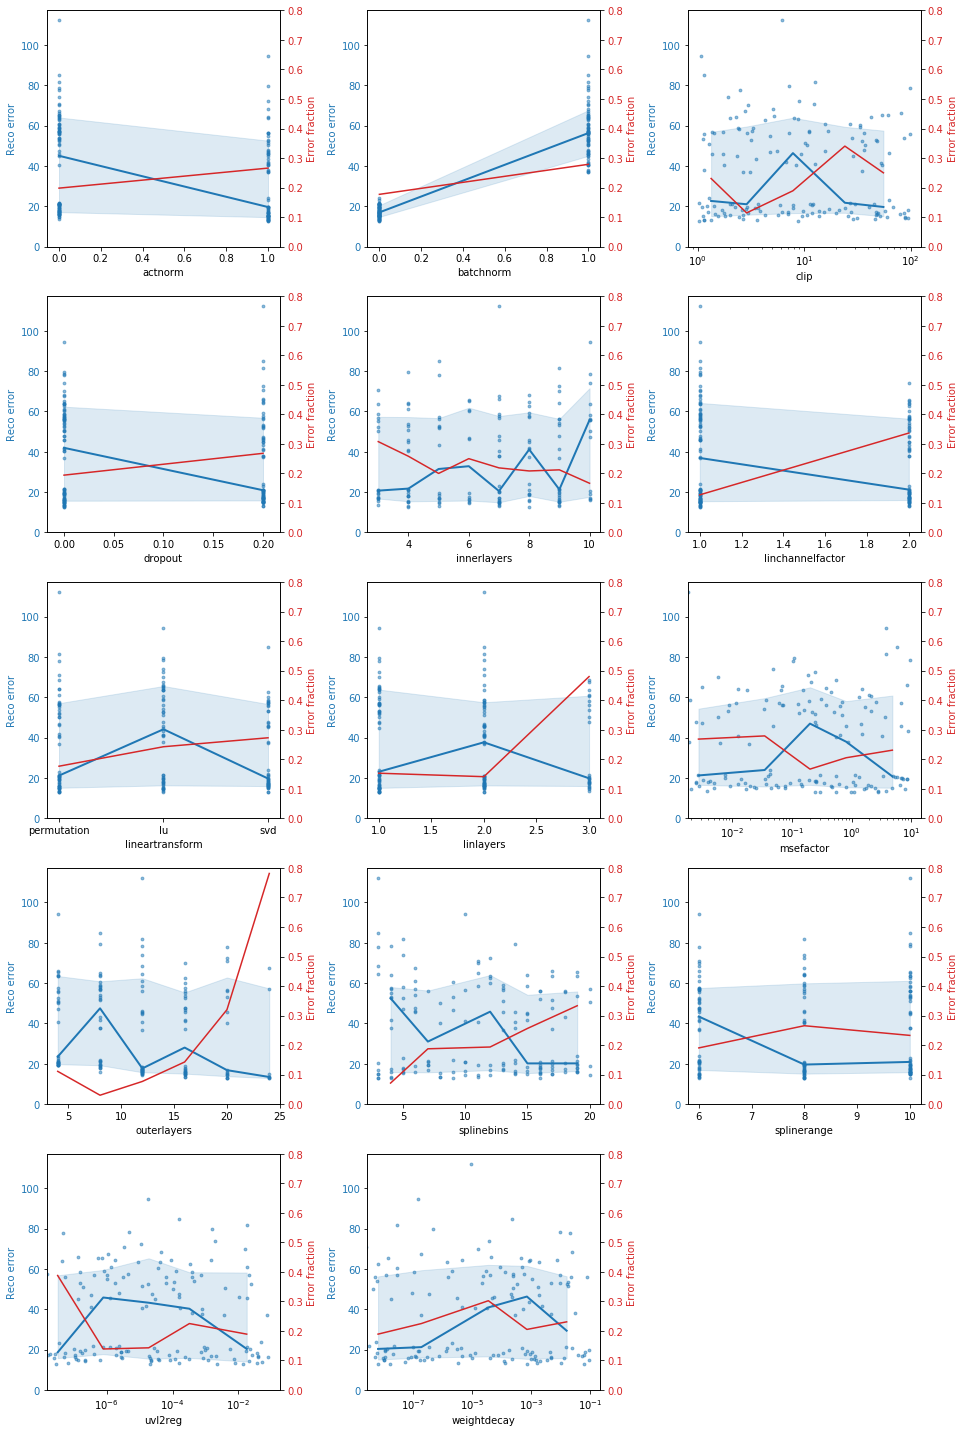

In [6]:
params = [c for c in results.columns if c != "value"]
n = len(params)
ncols = 3
nrows = (n - 1) // ncols + 1

y_err = 1.


plt.figure(figsize=(ncols * 4.5, nrows * 4))

for i, param in enumerate(params):
    ax = plt.subplot(nrows, ncols, i+1)
    
    x, y = results[param], results["value"]
    filter_ = y < 0.99e9
    x_ = x[filter_]
    y_ = y[filter_]
    y_err_min = 1.5 * np.max(y_)
    y_err_max = 1.7 * np.max(y_)
    
    if param in edge_dict:
        edges = edge_dict[param]
    else:
        edges = np.percentile(x_, np.linspace(0., 100., 6))
        
    if edges is None:  # Non-numeric x axes
        counter = Counter(x)
        x_dict = {label: val for val, label in enumerate(counter.keys())}
        x = np.array([x_dict[this_x] for this_x in x])
        x_ = x[filter_]
        edges = np.linspace(-0.5, len(counter.keys()) - 0.5, len(counter.keys()) + 1)
        plt.xticks((edges[1:] + edges[:-1])/2, list(counter.keys()))

    x_means = [np.median(x_[(x_ > min_)&(x_ < max_)]) for min_, max_ in zip(edges[:-1], edges[1:])]
    y_means = [np.median(y_[(x_ > min_)&(x_ < max_)]) for min_, max_ in zip(edges[:-1], edges[1:])]
    y_low = [np.percentile(y_[(x_ > min_)&(x_ < max_)], 16) for min_, max_ in zip(edges[:-1], edges[1:])]
    y_high = [np.percentile(y_[(x_ > min_)&(x_ < max_)], 84) for min_, max_ in zip(edges[:-1], edges[1:])]
    err_fraction = [1. - len(y_[(x_ > min_)&(x_ < max_)]) / len(y[(x > min_)&(x < max_)]) for min_, max_ in zip(edges[:-1], edges[1:])]
        
    ax.scatter(x_, y_, marker= "o", s=8., c="C0", alpha=0.5)

    ax.fill_between(x_means, y_low, y_high, color="C0", alpha=0.15)
    ax.plot(x_means, y_means, c="C0", lw=2.0)
    
    plt.xlabel(param)
    plt.ylabel("Reco error", color="C0")
    #plt.yscale("log")
    plt.ylim(0., None)
    if param in ["clip", "msefactor", "weightdecay", "uvl2reg"]:
        plt.xscale("log")
    ax.tick_params(axis='y', labelcolor="C0")
        
    ax2 = ax.twinx()
    ax2.set_ylabel('Error fraction', color="C3")
    ax2.plot(x_means, err_fraction, color="C3")
    ax2.tick_params(axis='y', labelcolor="C3")
    plt.ylim(0., 0.8)

plt.tight_layout()
plt.savefig("../figures/gan2d_paramscan.pdf")


## Best results

In [7]:
results.iloc[:3]

,value,actnorm,batchnorm,clip,dropout,innerlayers,linchannelfactor,lineartransform,linlayers,msefactor,outerlayers,splinebins,splinerange,uvl2reg,weightdecay
job_15_trial_1,12.802835,True,False,1.027086,0.0,8,1,permutation,1,1.113127,20,3,8.0,2.938742e-08,6.575258e-09
job_0_trial_0,12.843246,True,False,8.664731,0.0,4,1,lu,2,2.826056,24,9,8.0,2.207574e-03,1.657426e-08
job_13_trial_9,12.968833,True,False,1.151779,0.0,7,2,permutation,1,0.984056,20,16,10.0,1.409328e-02,7.152226e-04
